In [1]:
import os
import pandas as pd
import json
import folium

In [2]:
europe_geo_path = os.path.join('topojson', 'europe.topojson.json')
europe_json_data = json.load(open(europe_geo_path))

In [3]:
m = folium.Map([48.1176609, 4.0804824], tiles='cartodbpositron', zoom_start=4)
x = folium.TopoJson(data = europe_json_data, object_path = 'objects.europe')
x.add_to(m)

In [4]:
eurostat = pd.read_csv('./data/eurostat_ilo_definition.csv')
eurostat = eurostat[['TIME', 'GEO', 'GEO_LABEL', 'Value']]
eu_09 = eurostat.loc[eurostat['TIME'] == '2017M01']
eu_09['Value'] = eu_09['Value'].str.replace(":", "0").astype("float")
eu_09

C:\Users\Tarmo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,TIME,GEO,GEO_LABEL,Value
0,2017M01,BE,Belgium,7.6
1,2017M01,BG,Bulgaria,6.6
2,2017M01,CZ,Czech Republic,3.3
3,2017M01,DK,Denmark,6.1
4,2017M01,DE,Germany (until 1990 former territory of the FRG),3.9
5,2017M01,EE,Estonia,5.9
6,2017M01,IE,Ireland,6.9
7,2017M01,EL,Greece,23.1
8,2017M01,ES,Spain,18.4
9,2017M01,FR,France,9.7


In [5]:
m.choropleth(
    geo_data=europe_json_data,
    data=eu_09,
    columns=['GEO_LABEL', 'Value'],
    key_on='feature.properties.NAME',
    fill_color='PuBuGn',
    fill_opacity=0.8,
    line_opacity=0.2,
    legend_name='Unemployment Rate (%)',
    topojson = x.object_path
)
m

# Question 2 
# Amstat website

In [6]:
switz_geo_path = os.path.join('topojson', 'ch-cantons.topojson.json')
switz_json_data = json.load(open(switz_geo_path))

In [7]:
m_switz = folium.Map([46.7, 8.3], tiles='cartodbpositron', zoom_start=7)

folium.TopoJson(data = switz_json_data, object_path = 'objects.cantons').add_to(m_switz)
m_switz

4 columns have been extracted from the data of the amstat website, namely:
* 'taux de chômage'="rate of unemployment"
* 'demandeurs d'emploi'= "job seekers"
* 'chômeurs inscrit' = "unemployed"
* 'demandeurs d'emploi non chômeurs'="job seekers not unemployed"

The amstat website states that the "unemployment rate" ('taux de chomage') is calculated by dividing the number of "unemployed" people ('inscrits au chômage') by the people who are "active". Therefore we will consider that the first column does not account for the "job seekers not unemployed" ('demandeur d'emploi non inscrits au chômage').

The general "rate of job seekers" should be "job seeker"/"active people". Therefore, a column indicating the number of active people is needed and can be computed using "active"="unemployed"/"rate of unemployment". 

The rates of job seekers and unemployment can then be compared.




In [8]:
DATA_FOLDER = 'data'
swiss_employ_data = pd.read_excel(DATA_FOLDER+"/Unemployed_job_seekers_by_month.xlsx")


In [9]:
swiss_employ_data=swiss_employ_data.replace({ "'": ""}, regex=True)
swiss_employ_data

,Canton,Unemployment rate 01.17,Job seekers 01.17,Unemployed 01.17,Job seekers not unemployed 01.17,Unemployment rate 02.17,Job seekers 02.17,Unemployed 02.17,Job seekers not unemployed 02.17,Unemployment rate 03.17,...,Unemployed 07.17,Job seekers not unemployed 07.17,Unemployment rate 08.17,Job seekers 08.17,Unemployed 08.17,Job seekers not unemployed 08.17,Unemployment rate 09.17,Job seekers 09.17,Unemployed 09.17,Job seekers not unemployed 09.17
0,Zurich,3.9,39340,32387,6953,3.9,38748,31619,7129,3.8,...,27992,7120,3.4,34542,27514,7028,3.3,34156,27225,6931
1,Berne,3.0,21586,16954,4632,3.0,21367,16738,4629,2.9,...,13633,4809,2.5,18393,13829,4564,2.4,18385,13658,4727
2,Lucerne,2.2,7950,4985,2965,2.2,7857,4808,3049,2.0,...,3875,2930,1.8,6853,3992,2861,1.7,6756,3885,2871
3,Uri,1.5,464,297,167,1.4,457,276,181,1.3,...,129,136,0.6,267,123,144,0.6,257,112,145
4,Schwyz,2.0,2581,1794,787,2.0,2568,1766,802,1.9,...,1447,785,1.7,2240,1466,774,1.7,2229,1455,774
5,Obwald,1.0,378,217,161,1.1,403,228,175,1.0,...,176,134,0.8,322,164,158,0.7,319,153,166
6,Nidwald,1.3,535,305,230,1.3,551,306,245,1.2,...,241,193,1.0,425,247,178,1.0,436,248,188
7,Glaris,2.5,876,567,309,2.6,891,576,315,2.4,...,415,290,1.9,730,435,295,1.8,713,416,297
8,Zoug,2.6,2831,1756,1075,2.6,2879,1784,1095,2.5,...,1574,1133,2.4,2663,1604,1059,2.3,2615,1543,1072
9,Fribourg,3.2,9197,5215,3982,2.9,8941,4811,4130,2.7,...,4372,3383,2.8,7889,4667,3222,2.7,7837,4466,3371


In [10]:
'''
swiss_employ_df_2= swiss_employ_data.copy()

#delete the column containing strings
del swiss_employ_df_2['Canton']

#changing the object types to floats
swiss_employ_df_2=swiss_employ_df_2.astype('float64')

#adding a column for the active population and another for the job seekers rate
i=0
month=1
cols=swiss_employ_df_2.columns
while i < len(cols):
    
    unemp_col=cols[i+2]
    unemp_rate_col=cols[i]
    jobseek_col=cols[i+1]
    swiss_employ_df_2.insert(i+4, 'Actives'+ ' 0'+str(month) +'.17', swiss_employ_df_2[unemp_col] *100/swiss_employ_df_2[unemp_rate_col])
    activ_col=cols[i+4]
    swiss_employ_df_2.insert(i+5, 'Job seekers rate'+ ' 0'+str(month) +'.17', swiss_employ_df_2[jobseek_col] *100/swiss_employ_df_2[activ_col])
    i+=6
    month+=1
    
swiss_complete_df=swiss_employ_data[['Canton']].join(swiss_employ_data_2)
swiss_complete_df
'''

"\nswiss_employ_df_2= swiss_employ_data.copy()\n\n#delete the column containing strings\ndel swiss_employ_df_2['Canton']\n\n#changing the object types to floats\nswiss_employ_df_2=swiss_employ_df_2.astype('float64')\n\n#adding a column for the active population and another for the job seekers rate\ni=0\nmonth=1\ncols=swiss_employ_df_2.columns\nwhile i < len(cols):\n    \n    unemp_col=cols[i+2]\n    unemp_rate_col=cols[i]\n    jobseek_col=cols[i+1]\n    swiss_employ_df_2.insert(i+4, 'Actives'+ ' 0'+str(month) +'.17', swiss_employ_df_2[unemp_col] *100/swiss_employ_df_2[unemp_rate_col])\n    activ_col=cols[i+4]\n    swiss_employ_df_2.insert(i+5, 'Job seekers rate'+ ' 0'+str(month) +'.17', swiss_employ_df_2[jobseek_col] *100/swiss_employ_df_2[activ_col])\n    i+=6\n    month+=1\n    \nswiss_complete_df=swiss_employ_data[['Canton']].join(swiss_employ_data_2)\nswiss_complete_df\n"

# Question 3 - Swiss and foreign
**Part 1:** This time we distinguish between Swiss and foreign unemployed. We get the unemployment rate for non-Swiss and Swiss people in each canton, and take the difference between them (non-Swiss unemployment rate minus Swiss unemployment rate). The difference is in percentage points: a difference of 1 percentage point means that the rate of non-Swiss unemployment is n+1 % and the rate of Swiss unemployment is n %. We then plot this difference for each canton on the map of Switzerland for easy visual comparison between cantons. We plot the difference for three months in 2017 (January, May, and the most recent one, September). By default September is shown: the reader can switch between different months by choosing the desired month from the map sidebar.

The differences are most visible in the northwest of Switzerland in September. This might be due to the larger number of French people residing in Switzerland than for example Italian people. However, we notice that in January the highest difference is actually in Valais next to the Italian border, which might suggest that the situation changes significantly in time, and making spatial inferences can be difficult.

In [224]:
import matplotlib.pyplot as plt
import numpy as np

DATA_FOLDER = 'data'
# Read unemployment data for non-Swiss and Swiss for the year 2017
swiss_foreign = pd.read_excel(DATA_FOLDER+'/unemployed_job_seekers_by_month_by_nationality.xlsx')
swiss_foreign.head()

,Canton,Nationality,Unemployment rate 01.17,Unemployed 01.17,Job seekers 01.17,Job seekers not unemployed 01.17,Unemployment rate 02.17,Unemployed 02.17,Job seekers 02.17,Job seekers not unemployed 02.17,...,Job seekers 07.17,Job seekers not unemployed 07.17,Unemployment rate 08.17,Unemployed 08.17,Job seekers 08.17,Job seekers not unemployed 08.17,Unemployment rate 09.17,Unemployed 09.17,Job seekers 09.17,Job seekers not unemployed 09.17
0,Zurich,Foreigners,6.6,15'060,18'358,3'298,6.5,14'787,18'189,3'402,...,15'950,3'404,5.3,12'151,15'504,3'353,5.3,12'111,15'384,3'273
1,Zurich,Swiss,2.9,17'327,20'982,3'655,2.8,16'832,20'559,3'727,...,19'162,3'716,2.6,15'363,19'038,3'675,2.5,15'114,18'772,3'658
2,Berne,Foreigners,7.5,6'670,8'570,1'900,7.4,6'562,8'495,1'933,...,6'800,1'889,5.5,4'913,6'761,1'848,5.5,4'900,6'859,1'959
3,Berne,Swiss,2.2,10'284,13'016,2'732,2.1,10'176,12'872,2'696,...,11'642,2'920,1.9,8'916,11'632,2'716,1.8,8'758,11'526,2'768
4,Lucerne,Foreigners,5.4,2'221,3'550,1'329,5.1,2'094,3'524,1'430,...,2'893,1'302,3.9,1'606,2'915,1'309,3.9,1'593,2'902,1'309


In [225]:
swiss_foreign = swiss_foreign.replace({"'" : ""},regex=True)
swiss_foreign = swiss_foreign.apply(pd.to_numeric,errors='ignore')

# Differences between non-Swiss and Swiss in percentage points
differences = swiss_foreign[swiss_foreign.columns.difference(['Canton','Nationality'])].diff(-1)
differences = differences.iloc[::2,:]
for index in differences.index:
    differences.loc[index,'Canton'] = swiss_foreign.loc[index,'Canton']

# Since we want to match cantons in our topojson data,
# we need to define the id of each canton in our data frame.
# There's only 26 cantons, so we do it by hand.
differences.loc[0,'id'] = 'ZH'
differences.loc[2,'id'] = 'BE'
differences.loc[4,'id'] = 'LU'
differences.loc[6,'id'] = 'UR'
differences.loc[8,'id'] = 'SZ'
differences.loc[10,'id'] = 'OW'
differences.loc[12,'id'] = 'NW'
differences.loc[14,'id'] = 'GL'
differences.loc[16,'id'] = 'ZG'
differences.loc[18,'id'] = 'FR'
differences.loc[20,'id'] = 'SO'
differences.loc[22,'id'] = 'BS'
differences.loc[24,'id'] = 'BL'
differences.loc[26,'id'] = 'SH'
differences.loc[28,'id'] = 'AR'
differences.loc[30,'id'] = 'AI'
differences.loc[32,'id'] = 'SG'
differences.loc[34,'id'] = 'GR'
differences.loc[36,'id'] = 'AG'
differences.loc[38,'id'] = 'TG'
differences.loc[40,'id'] = 'TI'
differences.loc[42,'id'] = 'VD'
differences.loc[44,'id'] = 'VS'
differences.loc[46,'id'] = 'NE'
differences.loc[48,'id'] = 'GE'
differences.loc[50,'id'] = 'JU'

switz_geo_path = os.path.join('topojson', 'ch-cantons.topojson.json')
switz_json_data = json.load(open(switz_geo_path))
m_switz = folium.Map([46.7, 8.3], tiles='cartodbpositron', zoom_start=7)
x_switz = folium.TopoJson(data = switz_json_data,name='Borders', object_path = 'objects.cantons').add_to(m_switz)

m_switz.choropleth(
    geo_data=switz_json_data,
    name='January',
    data=differences,
    columns=['id', 'Unemployment rate 01.17'],
    key_on='feature.id',
    fill_color='BuGn',
    fill_opacity=1.0,
    line_opacity=0.2,
    legend_name='Difference in unemployment rate, percentage points (January 2017)',
    topojson = x_switz.object_path
)

m_switz.choropleth(
    geo_data=switz_json_data,
    name='May',
    data=differences,
    columns=['id', 'Unemployment rate 05.17'],
    key_on='feature.id',
    fill_color='PuBu',
    fill_opacity=1.0,
    line_opacity=0.2,
    legend_name='Difference in unemployment rate, percentage points (May 2017)',
    topojson = x_switz.object_path
)

m_switz.choropleth(
    geo_data=switz_json_data,
    name='September',
    data=differences,
    columns=['id', 'Unemployment rate 09.17'],
    key_on='feature.id',
    fill_color='OrRd',
    fill_opacity=1.0,
    line_opacity=0.2,
    legend_name='Difference in unemployment rate, percentage points (September 2017)',
    topojson = x_switz.object_path
)

folium.LayerControl(collapsed=False).add_to(m_switz)


m_switz

**Part 2:** Now we look simultaneously at differences between age groups, nationalities (non-Swiss and Swiss) and cantons. However, from the amstat website the unemployment rates grouped by all these categories is not available, so we will need to change our approach. We can get the number of unemployed grouped by each category, but we cannot calculate the rate of unemployment since we do not have the size of the *active* population grouped by each category (for example, non-Swiss 15-19 year olds in Zurich). This information is not readily available on external websites either, and the definitions of 'active' may vary between websites and data sets.

Therefore, we decided to take an approach that requires no further assumptions (for example, the assumption that the percentage of active people is the same in each age category for each nationality), and simply show data from which inferences can be made but where the reader will apply desired assumptions themselves.

We show the percentage of non-Swiss unemployed out of all unemployed (Swiss and non-Swiss) for each age category (15-19 year olds, 20-24 year olds, etc.) for each canton in one stacked bar plot. Since here the y-axis is somewhat hard to interpret (sum of relative proportions), we remove the values from it to prevent reader confusion. What is important is comparison between cantons, and by using a stacked bar plot we can easily see if there are differences between age categories and/or cantons.

From the plot we see that for example the proportion of non-Swiss unemployed is pretty much the same for 30-34 year olds in each canton, but the proportion for 15-19 year olds varies a lot between cantons. Some cantons have consistently high proportions for all age categories (e.g. Bâle-Ville), while others have consistently low proportions (e.g. Jura).

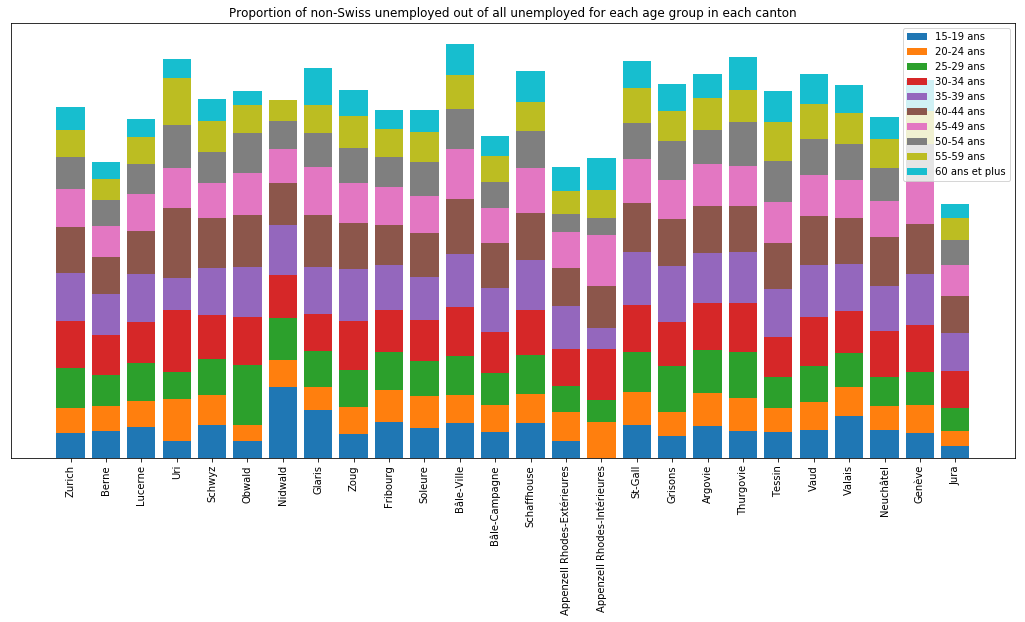

In [229]:
# Number of unemployed grouped by canton, nationality and age category
swiss_age_nat = pd.read_excel(DATA_FOLDER+'/Unemployed_job_seekers_by_month_by_age_by_nationality_clean.xlsx')
swiss_age_nat = swiss_age_nat.replace("...",np.NaN)

swiss_age_nat = swiss_age_nat.apply(pd.to_numeric,errors='ignore')
swiss_age_nat = swiss_age_nat.set_index(['Canton','Nationality','Age group'])


cantons = list(swiss_age_nat.index.get_level_values(0).unique())
age_groups = list(swiss_age_nat.index.get_level_values(2).unique())
tuples = list(zip(cantons,age_groups))
index = pd.MultiIndex.from_product([cantons,age_groups],names=['Canton','Age group'])
september_data = pd.DataFrame(data=[np.nan]*260,index=index)
september_data.columns = ['Value']


for canton in swiss_age_nat.index.get_level_values(0).unique():
    for age in swiss_age_nat.index.get_level_values(2).unique():
        non_swiss = swiss_age_nat.xs(canton).xs('Etrangers').xs(age)['Septembre 2017']
        swiss = swiss_age_nat.xs(canton).xs('Suisses').xs(age)['Septembre 2017']
        september_data.loc[canton,age]['Value'] = non_swiss/(swiss+non_swiss)


plt.figure(figsize=(18,8))
ind = np.arange(26)
previous_data = [0.0]*26
for age in age_groups:
    #print(age)
    data_list = []
    for canton in cantons:
        data_list.append(september_data.loc[canton,age]['Value'])
    p1 = plt.bar(ind,data_list,bottom=previous_data)
    p1.set_label(age)
    previous_data = list(np.array(data_list) + np.array(previous_data))
        
plt.legend()
plt.xticks(ind,cantons,rotation=90)
ax = plt.gca()
ax.yaxis.set_visible(False)
plt.title('Proportion of non-Swiss unemployed out of all unemployed for each age group in each canton')
plt.show()

**Bonus:** We show the unemployment rates for each age category and each canton without making a distinction between Swiss and non-Swiss to see what is the effect of age alone.

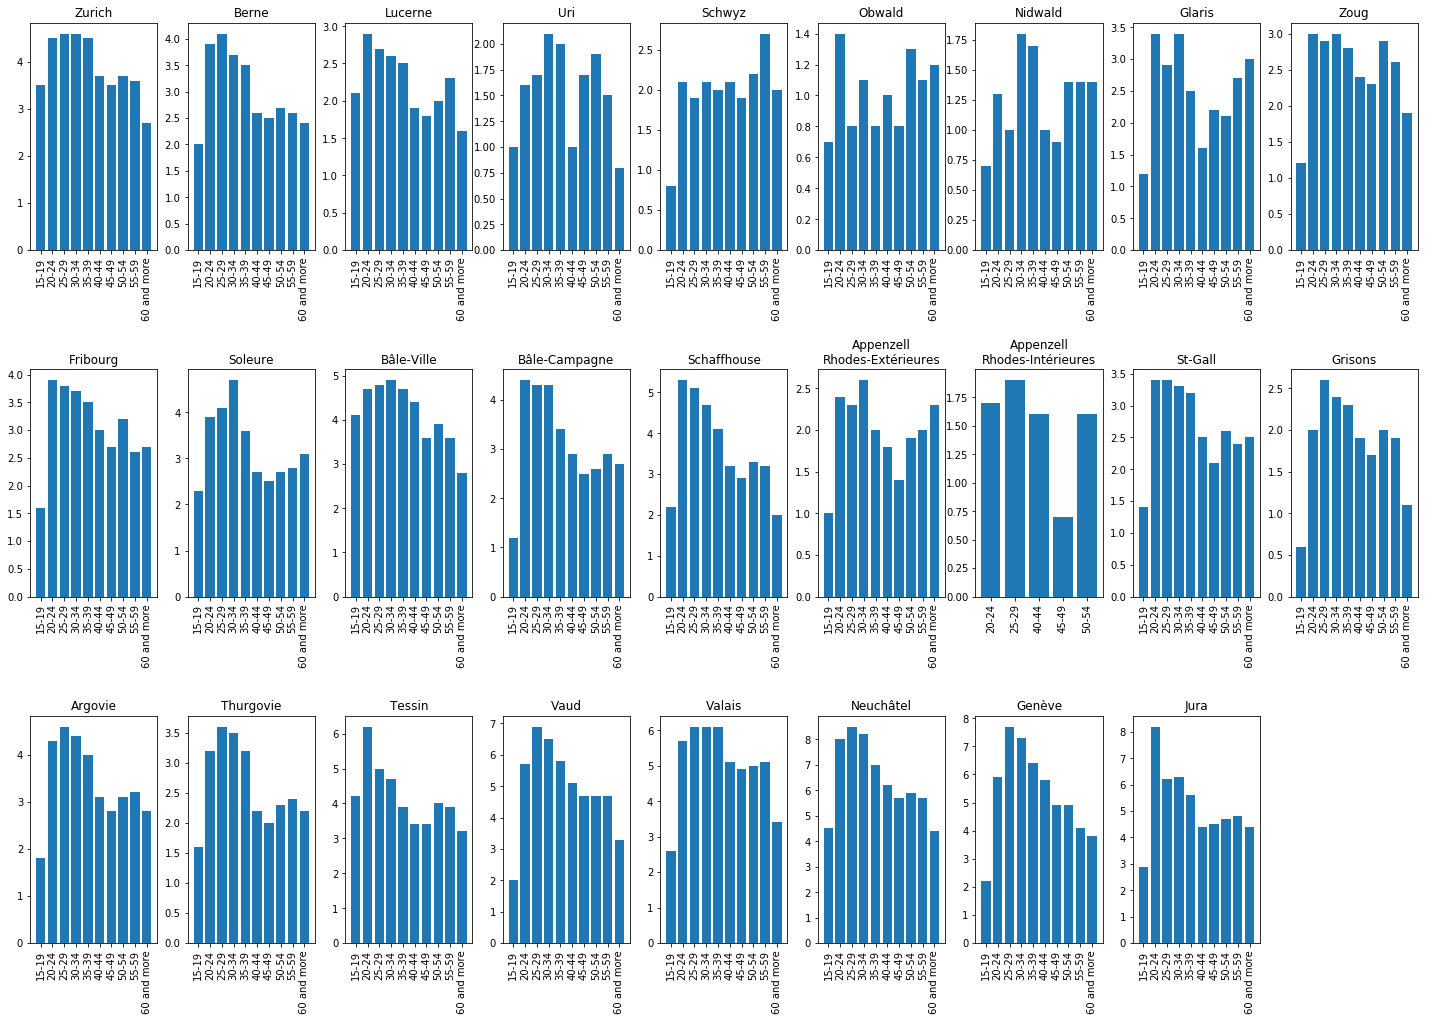

In [232]:
swiss_age = pd.read_excel(DATA_FOLDER+'/Unemployement_rates_by_age_category.xlsx')
swiss_age = swiss_age.replace({"'" : ""},regex=True)
swiss_age = swiss_age.replace("...",np.NaN)
swiss_age

swiss_age = swiss_age.apply(pd.to_numeric,errors='ignore')
swiss_age['Unemployment rate 09.17'].dtype
swiss_age['Unemployment rate 09.17'].apply(pd.to_numeric)
swiss_age = swiss_age[['Canton','Age group','Unemployment rate 01.17']]
swiss_age = swiss_age.set_index(['Canton','Age group'])

fig,axs = plt.subplots(3,9)
fig.set_figwidth(20)
fig.tight_layout()
fig.set_figheight(15)
fig.subplots_adjust(wspace=0.24)
ii = 0
jj = 0
for canton in swiss_age.index.get_level_values(0).unique():
    if ii != 0 and ii % 9 == 0:
        ii = 0
        jj += 1
    plt.sca(axs[jj,ii])
    #swiss_age.xs(canton).dropna().plot.bar()
    values = swiss_age.xs(canton).dropna().values
    labels = swiss_age.xs(canton).dropna().index
    plt.bar(range(len(values)),values)
    plt.xticks(range(len(values)),labels,rotation=90)
    if canton == 'Appenzell Rhodes-Extérieures':
        plt.title('Appenzell\nRhodes-Extérieures')
    elif canton == 'Appenzell Rhodes-Intérieures':
        plt.title('Appenzell\nRhodes-Intérieures')
    else:
        plt.title(canton)
    ii += 1

axs[2,8].axis('off')
plt.show()

In [12]:
swiss_foreign = swiss_foreign.replace({"'" : ""},regex=True)
swiss_foreign = swiss_foreign.apply(pd.to_numeric,errors='ignore')
swiss_foreign['Unemployed 01.17'].dtype

dtype('int64')

In [13]:
def subtraction(a,b):
    return a-b

#swiss_foreign['Unemployment rate 01.17'].diff(-1).iloc[::2]

differences = swiss_foreign[swiss_foreign.columns.difference(['Canton','Nationality'])].diff(-1)
differences = differences.iloc[::2,:]
for index in differences.index:
    differences.loc[index,'Canton'] = swiss_foreign.loc[index,'Canton']
    
#differences['Unemployment rate 01.17']
#differences = differences.iloc[::2,:]
#differences.loc[0]['Job seekers 01.17']

#differences['Canton'] = 0
#for index in differences.index:
    #differences.loc[index,'Canton'] = swiss_foreign.loc[index,'Canton']

#differences.loc[2,'Canton'] = 'ad'
#differences.loc[2,'Canton']
#df2 = df[df.columns.difference(['B', 'D'])]

differences.sort_index(axis=1)[['Canton','Unemployment rate 09.17']]

,Canton,Unemployment rate 09.17
0,Zurich,2.8
2,Berne,3.7
4,Lucerne,2.6
6,Uri,1.7
8,Schwyz,2.2
10,Obwald,1.7
12,Nidwald,2.2
14,Glaris,2.0
16,Zoug,2.2
18,Fribourg,3.0


In [14]:
#switz_geo_path = os.path.join('topojson', 'ch-cantons.topojson.json')
#switz_json_data = json.load(open(switz_geo_path))

#m_switz = folium.Map([46.7, 8.3], tiles='cartodbpositron', zoom_start=7)

#x_switz = folium.TopoJson(data = switz_json_data, object_path = 'objects.cantons').add_to(m_switz)
#m_switz

In [15]:
differences.loc[0,'id'] = 'ZH'
differences.loc[2,'id'] = 'BE'
differences.loc[4,'id'] = 'LU'
differences.loc[6,'id'] = 'UR'
differences.loc[8,'id'] = 'SZ'
differences.loc[10,'id'] = 'OW'
differences.loc[12,'id'] = 'NW'
differences.loc[14,'id'] = 'GL'
differences.loc[16,'id'] = 'ZG'
differences.loc[18,'id'] = 'FR'
differences.loc[20,'id'] = 'SO'
differences.loc[22,'id'] = 'BS'
differences.loc[24,'id'] = 'BL'
differences.loc[26,'id'] = 'SH'
differences.loc[28,'id'] = 'AR'
differences.loc[30,'id'] = 'AI'
differences.loc[32,'id'] = 'SG'
differences.loc[34,'id'] = 'GR'
differences.loc[36,'id'] = 'AG'
differences.loc[38,'id'] = 'TG'
differences.loc[40,'id'] = 'TI'
differences.loc[42,'id'] = 'VD'
differences.loc[44,'id'] = 'VS'
differences.loc[46,'id'] = 'NE'
differences.loc[48,'id'] = 'GE'
differences.loc[50,'id'] = 'JU'

In [16]:
'''
differences.loc[0,'Canton'] = u'Zürich'
differences.loc[2,'Canton'] = 'Bern/Berne'
differences.loc[4,'Canton'] = 'Luzern'
differences.loc[10,'Canton'] = 'Obwalden'
differences.loc[12,'Canton'] = 'Nidwalden'
differences.loc[14,'Canton'] = 'Glarus'
differences.loc[16,'Canton'] = 'Zug'
differences.loc[20,'Canton'] = 'Solothurn'
differences.loc[22,'Canton'] = 'Basel-Stadt'
differences.loc[24,'Canton'] = 'Basel-Landschaft'
differences.loc[26,'Canton'] = 'Schaffhausen'
differences.loc[28,'Canton'] = 'Appenzell Ausserrhoden'
differences.loc[30,'Canton'] = 'Appenzell Innerrhoden'
differences.loc[32,'Canton'] = 'St. Gallen'
differences.loc[34,'Canton'] = 'Graubünden/Grigioni'
differences.loc[36,'Canton'] = 'Aargau'
differences.loc[38,'Canton'] = 'Thurgau'
differences.loc[40,'Canton'] = 'Ticino'
differences.loc[44,'Canton'] = 'Valais/Wallis'
differences.loc[48,'Canton'] = 'Genève'
'''

"\ndifferences.loc[0,'Canton'] = u'Zürich'\ndifferences.loc[2,'Canton'] = 'Bern/Berne'\ndifferences.loc[4,'Canton'] = 'Luzern'\ndifferences.loc[10,'Canton'] = 'Obwalden'\ndifferences.loc[12,'Canton'] = 'Nidwalden'\ndifferences.loc[14,'Canton'] = 'Glarus'\ndifferences.loc[16,'Canton'] = 'Zug'\ndifferences.loc[20,'Canton'] = 'Solothurn'\ndifferences.loc[22,'Canton'] = 'Basel-Stadt'\ndifferences.loc[24,'Canton'] = 'Basel-Landschaft'\ndifferences.loc[26,'Canton'] = 'Schaffhausen'\ndifferences.loc[28,'Canton'] = 'Appenzell Ausserrhoden'\ndifferences.loc[30,'Canton'] = 'Appenzell Innerrhoden'\ndifferences.loc[32,'Canton'] = 'St. Gallen'\ndifferences.loc[34,'Canton'] = 'Graubünden/Grigioni'\ndifferences.loc[36,'Canton'] = 'Aargau'\ndifferences.loc[38,'Canton'] = 'Thurgau'\ndifferences.loc[40,'Canton'] = 'Ticino'\ndifferences.loc[44,'Canton'] = 'Valais/Wallis'\ndifferences.loc[48,'Canton'] = 'Genève'\n"

In [17]:
switz_geo_path = os.path.join('topojson', 'ch-cantons.topojson.json')
switz_json_data = json.load(open(switz_geo_path))
m_switz = folium.Map([46.7, 8.3], tiles='cartodbpositron', zoom_start=7)
x_switz = folium.TopoJson(data = switz_json_data,name='Borders', object_path = 'objects.cantons').add_to(m_switz)

m_switz.choropleth(
    geo_data=switz_json_data,
    name='January',
    data=differences,
    columns=['id', 'Unemployment rate 01.17'],
    key_on='feature.id',
    fill_color='BuGn',
    fill_opacity=1.0,
    line_opacity=0.2,
    legend_name='Difference in unemployment rate, percentage points (January 2017)',
    topojson = x_switz.object_path
)

m_switz.choropleth(
    geo_data=switz_json_data,
    name='May',
    data=differences,
    columns=['id', 'Unemployment rate 05.17'],
    key_on='feature.id',
    fill_color='PuBu',
    fill_opacity=1.0,
    line_opacity=0.2,
    legend_name='Difference in unemployment rate, percentage points (May 2017)',
    topojson = x_switz.object_path
)

m_switz.choropleth(
    geo_data=switz_json_data,
    name='September',
    data=differences,
    columns=['id', 'Unemployment rate 09.17'],
    key_on='feature.id',
    fill_color='OrRd',
    fill_opacity=1.0,
    line_opacity=0.2,
    legend_name='Difference in unemployment rate, percentage points (September 2017)',
    topojson = x_switz.object_path
)

#topojson = x_switz.object_path
folium.LayerControl(collapsed=False).add_to(m_switz)


m_switz

# Age groups

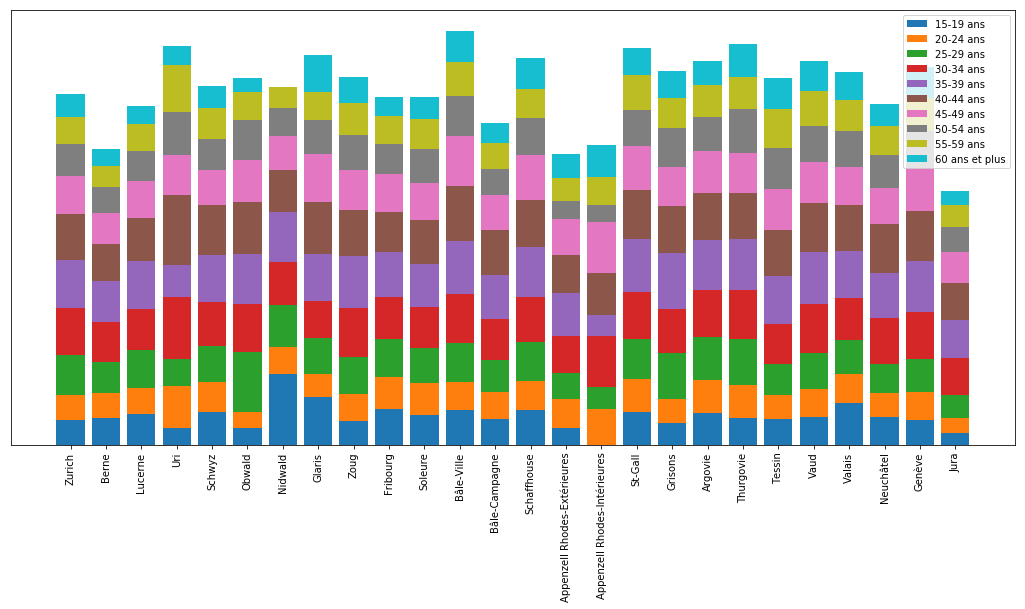

In [215]:
swiss_age_nat = pd.read_excel(DATA_FOLDER+'/Unemployed_job_seekers_by_month_by_age_by_nationality_clean.xlsx')
swiss_age_nat = swiss_age_nat.replace("...",np.NaN)
#swiss_age_nat.replace("*ans*","",regex=True)

swiss_age_nat = swiss_age_nat.apply(pd.to_numeric,errors='ignore')
swiss_age_nat = swiss_age_nat.set_index(['Canton','Nationality','Age group'])


cantons = list(swiss_age_nat.index.get_level_values(0).unique())
age_groups = list(swiss_age_nat.index.get_level_values(2).unique())
tuples = list(zip(cantons,age_groups))
index = pd.MultiIndex.from_product([cantons,age_groups],names=['Canton','Age group'])
september_data = pd.DataFrame(data=[np.nan]*260,index=index)
september_data.columns = ['Value']


for canton in swiss_age_nat.index.get_level_values(0).unique():
    for age in swiss_age_nat.index.get_level_values(2).unique():
        non_swiss = swiss_age_nat.xs(canton).xs('Etrangers').xs(age)['Septembre 2017']
        swiss = swiss_age_nat.xs(canton).xs('Suisses').xs(age)['Septembre 2017']
        september_data.loc[canton,age]['Value'] = non_swiss/(swiss+non_swiss)


plt.figure(figsize=(18,8))
ind = np.arange(26)
previous_data = [0.0]*26
for age in age_groups:
    #print(age)
    data_list = []
    for canton in cantons:
        data_list.append(september_data.loc[canton,age]['Value'])
    p1 = plt.bar(ind,data_list,bottom=previous_data)
    p1.set_label(age)
    previous_data = list(np.array(data_list) + np.array(previous_data))
    #if p1 == 0:
    #    p1 = plt.bar(ind,data_list)
    #else:
    #    p1 = plt.bar(ind,data_list,bottom=previous_data)
        
plt.legend()
plt.xticks(ind,cantons,rotation=90)
ax = plt.gca()
ax.yaxis.set_visible(False)
plt.show()

In [220]:
september_data.replace('ans','',inplace=True)
september_data

Value
Canton    Age group               
Zurich    15-19 ans       0.300082
          20-24 ans       0.294948
          25-29 ans       0.459598
          30-34 ans       0.562484
          35-39 ans       0.567395
          40-44 ans       0.530745
          45-49 ans       0.449217
          50-54 ans       0.376303
          55-59 ans       0.326334
          60 ans et plus  0.265113
Berne     15-19 ans       0.319859
          20-24 ans       0.289400
          25-29 ans       0.369693
          30-34 ans       0.468821
          35-39 ans       0.478316
          40-44 ans       0.438462
          45-49 ans       0.373418
          50-54 ans       0.304077
          55-59 ans       0.243451
          60 ans et plus  0.203166
Lucerne   15-19 ans       0.362069
          20-24 ans       0.307870
          25-29 ans       0.443775
          30-34 ans       0.490683
          35-39 ans       0.567198
          40-44 ans       0.500000
          45-49 ans       0.437666
          50-54 ans       0.355721
          55-59 ans       0.319588
          60 ans et plus  0.205882
...                            ...
Neuchâtel 15-19 ans       0.334821
          20-24 ans       0.280876
          25-29 ans       0.340157
          30-34 ans       0.539363
          35-39 ans       0.535587
          40-44 ans       0.567460
          45-49 ans       0.429379
          50-54 ans       0.387446
          55-59 ans       0.339713
          60 ans et plus  0.264026
Genève    15-19 ans       0.292929
          20-24 ans       0.328834
          25-29 ans       0.392544
          30-34 ans       0.551093
          35-39 ans       0.597826
          40-44 ans       0.593846
          45-49 ans       0.507659
          50-54 ans       0.429630
          55-59 ans       0.398159
          60 ans et plus  0.354680
Jura      15-19 ans       0.136364
          20-24 ans       0.185000
          25-29 ans       0.273196
          30-34 ans       0.426230
          35-39 ans       0.454545
          40-44 ans       0.433962
          45-49 ans       0.361257
          50-54 ans       0.292818
          55-59 ans       0.261146
          60 ans et plus  0.170732

[260 rows x 1 columns]

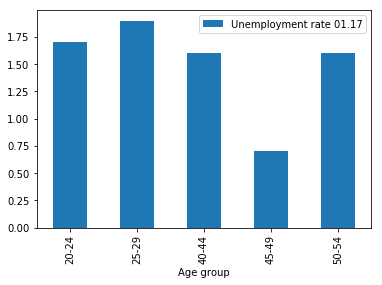

Index(['Zurich', 'Berne', 'Lucerne', 'Uri', 'Schwyz', 'Obwald', 'Nidwald',
       'Glaris', 'Zoug', 'Fribourg', 'Soleure', 'Bâle-Ville', 'Bâle-Campagne',
       'Schaffhouse', 'Appenzell Rhodes-Extérieures',
       'Appenzell Rhodes-Intérieures', 'St-Gall', 'Grisons', 'Argovie',
       'Thurgovie', 'Tessin', 'Vaud', 'Valais', 'Neuchâtel', 'Genève', 'Jura'],
      dtype='object', name='Canton')

In [18]:
import matplotlib.pyplot as plt
import numpy as np

swiss_age = pd.read_excel(DATA_FOLDER+'/Unemployement_rates_by_age_category.xlsx')
swiss_age = swiss_age.replace({"'" : ""},regex=True)
swiss_age = swiss_age.replace("...",np.NaN)
swiss_age

swiss_age = swiss_age.apply(pd.to_numeric,errors='ignore')
swiss_age['Unemployment rate 09.17'].dtype
swiss_age['Unemployment rate 09.17'].apply(pd.to_numeric)
swiss_age = swiss_age[['Canton','Age group','Unemployment rate 01.17']]
swiss_age = swiss_age.set_index(['Canton','Age group'])

swiss_age.xs('Appenzell Rhodes-Intérieures').dropna().plot.bar()
plt.show()

swiss_age.index.get_level_values(0).unique()

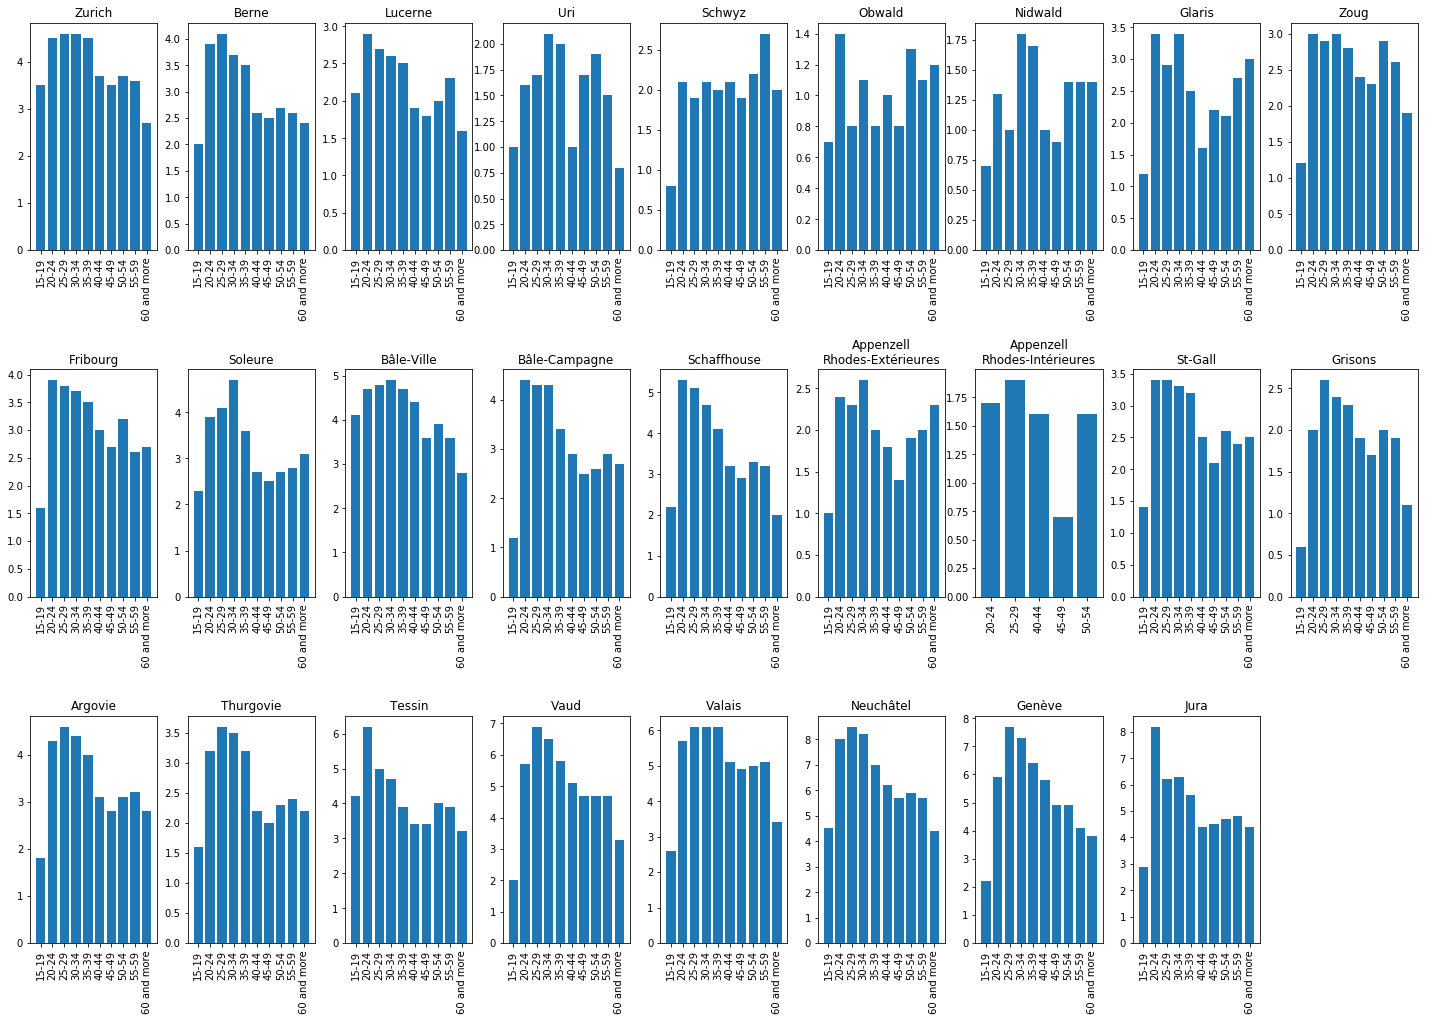

In [19]:
plt.close('all')
fig,axs = plt.subplots(3,9)
fig.set_figwidth(20)
fig.tight_layout()
fig.set_figheight(15)
fig.subplots_adjust(wspace=0.24)
ii = 0
jj = 0
for canton in swiss_age.index.get_level_values(0).unique():
    if ii != 0 and ii % 9 == 0:
        ii = 0
        jj += 1
    plt.sca(axs[jj,ii])
    #swiss_age.xs(canton).dropna().plot.bar()
    values = swiss_age.xs(canton).dropna().values
    labels = swiss_age.xs(canton).dropna().index
    plt.bar(range(len(values)),values)
    plt.xticks(range(len(values)),labels,rotation=90)
    if canton == 'Appenzell Rhodes-Extérieures':
        plt.title('Appenzell\nRhodes-Extérieures')
    elif canton == 'Appenzell Rhodes-Intérieures':
        plt.title('Appenzell\nRhodes-Intérieures')
    else:
        plt.title(canton)
    ii += 1

#plt.sca(axs[0])
#values = swiss_age.xs('Zurich').dropna().values
#labels = swiss_age.xs('Zurich').dropna().index
#plt.bar(range(len(values)),values)
#plt.xticks(range(len(values)),labels,rotation=90)

axs[2,8].axis('off')
plt.show()

In [20]:
swiss_age.xs('Zurich').index

Index(['15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54',
       '55-59', '60 and more'],
      dtype='object', name='Age group')

In [196]:
swiss_age_nat = pd.read_excel(DATA_FOLDER+'/Unemployed_job_seekers_by_month_by_age_by_nationality_clean.xlsx')
#swiss_age_nat = swiss_age_nat.replace({" " : ""},regex=True)
swiss_age_nat = swiss_age_nat.replace("...",np.NaN)

swiss_age_nat = swiss_age_nat.apply(pd.to_numeric,errors='ignore')
swiss_age_nat['Septembre 2017'].dtype
#swiss_age['Unemployment rate 09.17'].apply(pd.to_numeric)
#swiss_age = swiss_age[['Canton','Age group','Unemployment rate 01.17']]
swiss_age_nat = swiss_age_nat.set_index(['Canton','Nationality','Age group'])

#swiss_age_nat.loc['Zurich','Etrangers']

In [187]:
sept = swiss_age_nat['Septembre 2017']
swiss_age_nat.index.get_level_values(2).unique()

Index(['15-19 ans', '20-24 ans', '25-29 ans', '30-34 ans', '35-39 ans',
       '40-44 ans', '45-49 ans', '50-54 ans', '55-59 ans', '60 ans et plus'],
      dtype='object', name='Age group')

In [188]:
swiss_age_nat.xs('Zurich').xs('Etrangers').xs('15-19 ans')['Septembre 2017']/swiss_age_nat.xs('Zurich').xs('Suisses').xs('15-19 ans')['Septembre 2017']

0.42873831775700932

In [189]:
cantons = list(swiss_age_nat.index.get_level_values(0).unique())
age_groups = list(swiss_age_nat.index.get_level_values(2).unique())
tuples = list(zip(cantons,age_groups))
index = pd.MultiIndex.from_product([cantons,age_groups],names=['Canton','Age group'])
september_data = pd.DataFrame(data=[np.nan]*260,index=index)
september_data.columns = ['Value']

In [190]:
for canton in swiss_age_nat.index.get_level_values(0).unique():
    for age in swiss_age_nat.index.get_level_values(2).unique():
        non_swiss = swiss_age_nat.xs(canton).xs('Etrangers').xs(age)['Septembre 2017']
        swiss = swiss_age_nat.xs(canton).xs('Suisses').xs(age)['Septembre 2017']
        #september_data.set_value([canton,age],'Value',swiss)
        #september_data[canton][age] = non_swiss/(swiss+non_swiss)
        september_data.loc[canton,age]['Value'] = non_swiss/(swiss+non_swiss)

In [201]:
september_data
list(september_data.index.get_level_values(1).unique())
september_data.loc['Appenzell Rhodes-Intérieures','15-19 ans']

Value    0.0
Name: (Appenzell Rhodes-Intérieures, 15-19 ans), dtype: float64

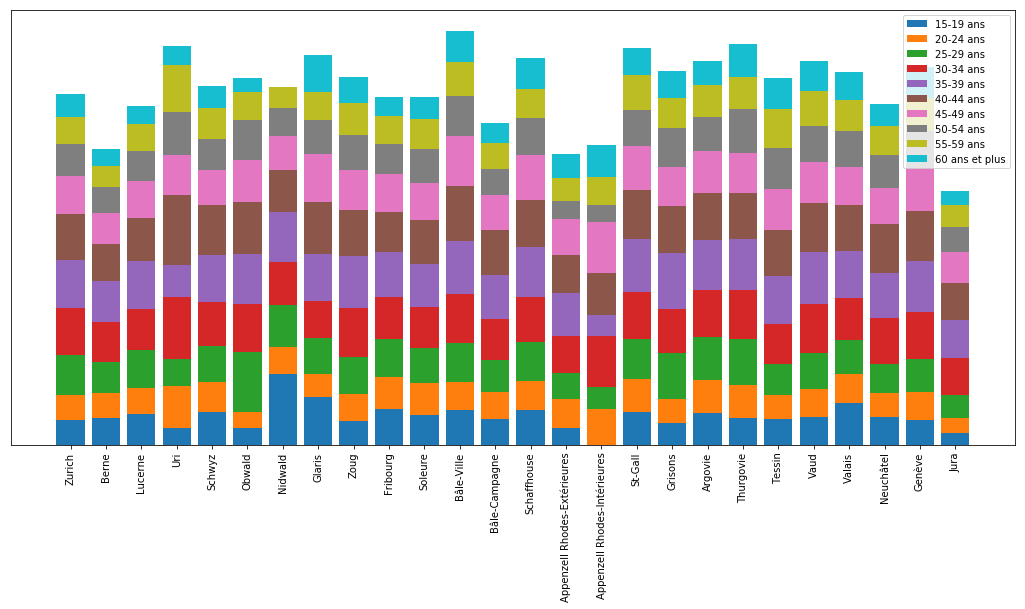

In [192]:
ind = np.arange(26)
p1 = 0
previous_data = [0.0]*26
cantons = list(september_data.index.get_level_values(0).unique())
ages = list(september_data.index.get_level_values(1).unique())
#ages = ['15-19 ans','20-24 ans','25-29 ans']

plt.figure(figsize=(18,8))
for age in ages:
    #print(age)
    data_list = []
    for canton in cantons:
        data_list.append(september_data.loc[canton,age]['Value'])
    p1 = plt.bar(ind,data_list,bottom=previous_data)
    p1.set_label(age)
    previous_data = list(np.array(data_list) + np.array(previous_data))
    #if p1 == 0:
    #    p1 = plt.bar(ind,data_list)
    #else:
    #    p1 = plt.bar(ind,data_list,bottom=previous_data)
        
plt.legend()
plt.xticks(ind,cantons,rotation=90)
ax = plt.gca()
ax.yaxis.set_visible(False)
plt.show()
        
#p1 = plt.bar(ind,)

In [172]:
np.array([1,2]) + np.array([3,4])

array([4, 6])